# Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Feger/limited-generalizability

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Feger/limited-generalizability


In [2]:
! pip install pingouin==0.5.5
! pip install scrubadub==2.0.1
! pip install emoji==2.4.0
! pip install contractions==0.1.73
! pip install tldextract==5.1.1
! pip install spacy==3.7.5
! pip install textdescriptives==2.8.2
! pip install spacytextblob==4.0.0
! python -m spacy download en_core_web_lg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.19.0
    Uninstalling textblob-0.19.0:
      Successfully uninstalled textblob-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350808 sha256=44f8c0ea6358fb809e33578411e4077ee0b4a19132cc6ad80a0a473818d8a970
  Stored i

In [3]:
import ast
import os
import re
import ftfy
import nltk
import emoji
import spacy
import string
import tldextract
import contractions
import scrubadub
import warnings
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import textdescriptives as td
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from spacytextblob.spacytextblob import SpacyTextBlob
from collections import Counter
from google.colab import runtime

warnings.filterwarnings("ignore")

# Get times font
font_path = "./output/images/times.ttf"

# Load the font in Matplotlib
times_new_roman_font = fm.FontProperties(fname=font_path, size=12)

# Set Pandas display options to show all rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 27)

# Load Scrubber
scrubber = scrubadub.Scrubber(post_processor_list=[scrubadub.post_processors.PrefixSuffixReplacer(prefix='_', suffix='_')])
for detector in list(scrubber._detectors):
    if detector not in ["email", "url"]:
        scrubber.remove_detector(detector)
assert sorted(list(scrubber._detectors)) == ["email", "url"]

# Load tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Load the nlp model for spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_lg", disable=['ner', 'parser', 'textcat', 'senter'])
nlp.add_pipe('spacytextblob')
nlp.add_pipe("textdescriptives/readability")
nlp.add_pipe("textdescriptives/information_theory")

# Enable progress_apply for pandas via tqdm
tqdm.pandas()

# Paths for data
DATA_PATH = "./data/all_data.csv"
PREPROCESSED_DATA_PATH = "./data/all_data_preprocessed.csv"
FEATURES_PATH = "./data/all_data_features.csv"
SAMPLE_PATH = "./data/sample.csv"
DATA_STATISTICS_PATH = "./output/statistics/all_data_statistics.csv"

# Define POS tag categories
OPEN_CLASS_TAGS = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN', 'VERB']
CLOSED_CLASS_TAGS = ['ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON', 'SCONJ']
OTHER_TAGS = ['PUNCT', 'SYM', 'X']
ALL_POS_TAGS = OPEN_CLASS_TAGS + CLOSED_CLASS_TAGS + OTHER_TAGS

# Defining the random states
random_states = [42, 51099, 374318]
sample_size_per_label = 850

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Preprocessing

In [4]:
def preprocess(text):
    PLACEHOLDER_REF = "[REF]"
    PLACEHOLDER_HASHTAG = "__HASHTAG__"
    PLACEHOLDER_AT = "__AT__"
    PLACEHOLDER_EMAIL = "__EMAIL__"
    PLACEHOLDER_URL = "__URL__"
    PLACEHOLDER_UNKNOWN = "__UNKNOWN__"
    for placeholders in [PLACEHOLDER_HASHTAG, PLACEHOLDER_AT, PLACEHOLDER_EMAIL, PLACEHOLDER_URL, PLACEHOLDER_UNKNOWN]:
        assert not placeholders in text
    # Unify text
    text = ftfy.fix_text(text)
    text = contractions.fix(text)
    text = scrubber.clean(text)
    text = re.sub(r'(https?://[^\s]+|www\.[^\s]+|[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})', PLACEHOLDER_REF, text)
    # Tweet specific replacements
    text = re.sub(r'(\#\w+)', lambda m: PLACEHOLDER_HASHTAG + m.group(0)[1:], text)
    text = re.sub(r'(@\w+)', lambda m: PLACEHOLDER_AT + m.group(0)[1:], text)
    text = text.replace("<MENTION>", "")
    text = emoji.demojize(text)
    text = text.replace("::", ": :")
    text = re.sub(r':(\w+):', r'\1', text)
    # Reference specific replacements
    text = text.replace('pseudo-url', PLACEHOLDER_REF)
    text = text.replace('<EQN>', PLACEHOLDER_REF)
    text = text.replace('<VAR>', PLACEHOLDER_REF)
    text = text.replace('<URL>', PLACEHOLDER_REF)
    text = text.replace('<CIT>', PLACEHOLDER_REF)
    text = text.replace(PLACEHOLDER_EMAIL, PLACEHOLDER_REF)
    text = text.replace(PLACEHOLDER_URL, PLACEHOLDER_REF)
    text = text.replace(PLACEHOLDER_UNKNOWN, PLACEHOLDER_REF)
    # Splitting sentences by words
    text = word_tokenize(text)
    text = " ".join(text)
    text = text.replace(PLACEHOLDER_HASHTAG, "#")
    text = text.replace(PLACEHOLDER_AT, "@")
    for placeholders in [PLACEHOLDER_HASHTAG, PLACEHOLDER_AT, PLACEHOLDER_EMAIL, PLACEHOLDER_URL, PLACEHOLDER_UNKNOWN]:
        assert not placeholders in text
    return text.lower()

In [5]:
if not os.path.exists(PREPROCESSED_DATA_PATH):
    df_data = pd.read_csv(DATA_PATH)
    df_data["sentence"] = df_data["sentence"].progress_apply(lambda sentence: preprocess(sentence))
    df_data.to_csv(PREPROCESSED_DATA_PATH, index=False)
df_data = pd.read_csv(PREPROCESSED_DATA_PATH)

# Text Feature Generation

In [6]:
def create_features(df):
    df = df.copy()
    # Initialize lists to store calculated features for each sentence
    features = {
        'pos_tags': [],
        'n_words': [],
        'stop_word_ratio': [],
        'type_token_ratio': [],
        'flesch_reading_ease': [],
        'entropy': [],
        'polarity': [],
        'subjectivity': []
    }

    assert not df['sentence'].isna().any(), "Sentences column contains NaN values."

    # Pre-define ranges for cleaning (avoid repeated operations)
    feature_ranges = {
        'flesch_reading_ease': (0, 100),
        'entropy': (0, 1),
        'polarity': (-1, 1),
        'subjectivity': (0, 1),
        'stop_word_ratio': (0, 1),
        'type_token_ratio': (0, 1)
    }

    # Loop through the sentences
    for text in tqdm(df['sentence'], desc="Processing Text"):
        doc = nlp(text)
        doc_words = [token.text.lower() for token in doc if token.text not in string.punctuation and not token.is_space]
        doc_len = len(doc_words)
        unique_words_len = len(set(doc_words))
        stop_word_count = sum(1 for token in doc if token.is_stop)
        flesch_score = doc._.readability['flesch_reading_ease']
        entropy_score = doc._.information_theory['entropy']
        # Calculating and appending results
        features['pos_tags'].append([(token.text, token.pos_) for token in doc])
        features['n_words'].append(doc_len)
        features['stop_word_ratio'].append(round(stop_word_count / doc_len, 4) if doc_len > 0 else 0)
        features['type_token_ratio'].append(round(unique_words_len / doc_len, 4) if doc_len > 0 else 0)
        features['flesch_reading_ease'].append(round(flesch_score, 4) if not np.isnan(flesch_score) else 50)
        features['entropy'].append(round(entropy_score / np.log(len(doc)), 4) if len(doc) > 1 else 0.5)
        features['polarity'].append(round(doc._.blob.polarity, 4))
        features['subjectivity'].append(round(doc._.blob.subjectivity, 4))

    # Append the extracted features to the DataFrame
    for feature, data in features.items():
        df[feature] = data

    # Range cleaning using 'clip' for efficient range enforcement
    for feature, (min_val, max_val) in feature_ranges.items():
        df[feature] = df[feature].clip(lower=min_val, upper=max_val)

    return df

In [7]:
if not os.path.exists(FEATURES_PATH):
    df_features = create_features(df_data)
    df_features.loc[:, ["dataset_id"]].join(df_features.iloc[:, len(df_data.columns):]).to_csv(FEATURES_PATH, index=False)
df_features = pd.read_csv(FEATURES_PATH)
df_features['pos_tags'] = df_features['pos_tags'].progress_apply(ast.literal_eval)
assert not df_features.isna().any().any()

  0%|          | 0/373086 [00:00<?, ?it/s]

# Data Selection

In [8]:
def proper_sentence_filter(df):
    return df["sentence"].str.endswith(tuple(string.punctuation)) & \
           df["pos_tags"].apply(lambda pos_tags: not all(tag == 'PUNCT' for _, tag in pos_tags))

def count_pos_tags(pos_tags):
    pos_tags_only = [tag for _, tag in pos_tags]
    pos_counts = Counter(pos_tags_only)
    return {tag: pos_counts.get(tag, 0) for tag in ALL_POS_TAGS}

def get_statistics(df):
    all_means = []
    all_sizes = []

    for dataset in df.dataset.unique():
        df_ = df[df["dataset"] == dataset]
        proper_sentences = proper_sentence_filter(df_)

        # Apply the function to count POS tags and add as new columns for each POS tag
        pos_tag_counts_df = df_['pos_tags'].apply(count_pos_tags).apply(pd.Series)
        df_ = pd.concat([df_, pos_tag_counts_df], axis=1)

        df_per_label = df_.groupby(['dataset', 'label'])
        df_per_dataset = df_.groupby(['dataset'])

        # Calculate means
        df_stat_per_label_mean = df_per_label[df_.columns[7:]].mean().round(2).reset_index()
        df_stat_per_dataset_mean = df_per_dataset[df_.columns[7:]].mean().round(2).reset_index()
        df_stat_per_dataset_mean["label"] = "Total"

        # Calculate size per label and per dataset
        df_size_per_label = df_per_label.size().reset_index(name="size")
        df_size_per_dataset = df_per_dataset.size().reset_index(name="size")
        df_size_per_dataset["label"] = "Total"

        # Calculate proper sentence counts
        df_size_per_label["proper"] = df_[proper_sentences].groupby(['dataset', 'label']).size().reset_index(name="proper")["proper"]
        df_size_per_dataset["proper"] = df_[proper_sentences].groupby(['dataset']).size().reset_index(name="proper")["proper"]

        # Concatenate means with sizes
        means = pd.concat([df_stat_per_label_mean, df_stat_per_dataset_mean], ignore_index=True)
        sizes = pd.concat([df_size_per_label, df_size_per_dataset], ignore_index=True)

        # Append to lists
        all_means.append(means)
        all_sizes.append(sizes)

    # Concatenate all dataset statistics together
    df_means = pd.concat(all_means)
    df_sizes = pd.concat(all_sizes)

    # Sort values
    df_means = df_means.sort_values(by=['dataset', 'label']).reset_index(drop=True)
    df_sizes = df_sizes.sort_values(by=['dataset', 'label']).reset_index(drop=True)

    return df_sizes.merge(df_means, on=['dataset', 'label'])

In [9]:
df_data = df_data.merge(df_features, on='dataset_id')

In [10]:
if not os.path.exists(DATA_STATISTICS_PATH):
    df_data_statistics = get_statistics(df_data)
    # Tweets don't follow proper sentence structure
    df_data_statistics.loc[df_data_statistics["dataset"].isin(["TACO", "SDAT", "ASC"]), "proper"] = df_data_statistics.loc[df_data_statistics["dataset"].isin(["TACO", "SDAT", "ASC"]), "size"]
    df_data_statistics.to_csv(DATA_STATISTICS_PATH, index=False)

df_data_statistics = pd.read_csv(DATA_STATISTICS_PATH)

## Dataset Selection

In [11]:
data_by_min_size = []
for group, values in df_data_statistics[["dataset", "size"]].groupby('dataset'):
    data_by_min_size.append((group, min(values["size"].tolist())))

data_by_min_size.sort(key=lambda v: v[1])
for i, v in list(enumerate(data_by_min_size)):
    min_size = v[1]
    train = int(min_size * 0.6)
    dev = int(min_size * 0.2)
    test = int(min_size * 0.2)
    print(f"Exclude: {i}/{len(data_by_min_size)} ({round(i/len(data_by_min_size), 3)}%) at threshold < {min_size} ({v[0]}), train: {train}, dev: {dev}, test: {test}")

Exclude: 0/28 (0.0%) at threshold < 112 (MT), train: 67, dev: 22, test: 22
Exclude: 1/28 (0.036%) at threshold < 147 (ASC), train: 88, dev: 29, test: 29
Exclude: 2/28 (0.071%) at threshold < 210 (SDAT), train: 126, dev: 42, test: 42
Exclude: 3/28 (0.107%) at threshold < 211 (WD), train: 126, dev: 42, test: 42
Exclude: 4/28 (0.143%) at threshold < 242 (AMPERE), train: 145, dev: 48, test: 48
Exclude: 5/28 (0.179%) at threshold < 260 (ASRD), train: 156, dev: 52, test: 52
Exclude: 6/28 (0.214%) at threshold < 414 (ECHR), train: 248, dev: 82, test: 82
Exclude: 7/28 (0.25%) at threshold < 547 (VG), train: 328, dev: 109, test: 109
Exclude: 8/28 (0.286%) at threshold < 561 (AMSR), train: 336, dev: 112, test: 112
Exclude: 9/28 (0.321%) at threshold < 702 (OC), train: 421, dev: 140, test: 140
Exclude: 10/28 (0.357%) at threshold < 733 (QMC), train: 439, dev: 146, test: 146
Exclude: 11/28 (0.393%) at threshold < 864 (TACO), train: 518, dev: 172, test: 172
Exclude: 12/28 (0.429%) at threshold < 97

In [12]:
selected_datasets = df_data_statistics.groupby('dataset').filter(
    lambda group: (
            (group['size'] >= sample_size_per_label).all()
        )
    ).dataset.unique()

## Random Sampling

In [13]:
def check_split_distribution(df, expected_counts):
    split_counts = df.groupby(['dataset', 'split']).size().unstack(fill_value=0)
    valid_splits = split_counts.apply(lambda x: x.to_dict() == expected_counts, axis=1)
    assert all(valid_splits)

def stratified_split(group, label_col, random_seed):
    # Create a copy to avoid modifying the original DataFrame
    group = group.copy()
    # Split: 60% train, 40% remaining
    train_idx, remaining_idx = train_test_split(group.index, test_size=0.4, stratify=group[label_col], random_state=random_seed)
    dev_idx, test_idx = train_test_split(remaining_idx, test_size=0.5, stratify=group.loc[remaining_idx, label_col], random_state=random_seed)
    group.loc[train_idx, 'split'] = 'train'
    group.loc[dev_idx, 'split'] = 'dev'
    group.loc[test_idx, 'split'] = 'test'
    sentence_idx = group.columns.get_loc('sentence') + 1
    columns = list(group.columns)
    columns.insert(sentence_idx, columns.pop(columns.index('split')))
    group = group[columns]
    return group

def create_sample(df, selection, size, random_seed):
    # Filter the selected datasets
    df_selected = df[df['dataset'].isin(selection)]

    # Apply the punctuation filter for all datasets except TACO
    df_selected_proper = df_selected[
        (df_selected['dataset'] != 'TACO') &
        proper_sentence_filter(df_selected)
    ]

    # Sample sentences per group for those datasets (that end with proper punctuation)
    df_sample_proper = df_selected_proper.groupby(['dataset', 'label']).sample(size, random_state=random_seed)

    # For TACO, sample sentences without filtering for punctuation
    df_taco_data = df_selected[df_selected['dataset'] == 'TACO']
    df_sample_taco = df_taco_data.groupby(['dataset', 'label']).sample(size, random_state=random_seed)

    # Combine the sampled data (from both conditions)
    df_sample = pd.concat([df_sample_proper, df_sample_taco])
    # Create splits
    df_sample = df_sample.groupby('dataset').apply(lambda x: stratified_split(x, label_col='label', random_seed=random_seed)).reset_index(drop=True)
    assert df_sample["pos_tags"].apply(lambda pos_tags: not all(tag == 'PUNCT' for _, tag in pos_tags)).all()
    return df_sample

In [14]:
for random_state in random_states:
    df_sample = create_sample(df_data, selected_datasets, sample_size_per_label, random_state)
    check_split_distribution(df_sample, {'train': 1020, 'dev': 340, 'test': 340})
    assert df_sample["dataset_id"].nunique() == 17*1700
    assert not df_sample[df_sample["split"] == "train"].dataset_id.isin(df_sample[df_sample["split"] == "dev"].dataset_id).any()
    assert not df_sample[df_sample["split"] == "train"].dataset_id.isin(df_sample[df_sample["split"] == "test"].dataset_id).any()
    assert not df_sample[df_sample["split"] == "dev"].dataset_id.isin(df_sample[df_sample["split"] == "test"].dataset_id).any()
    df_sample.to_csv(f"./data/sample_{random_state}.csv", index=False)

#Summary

## Requirements

In [15]:
def overlaps(a, b):
    set_a = set(a)
    set_b = set(b)
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union > 0 else 0

def sample_overlap_of_instances(df1, df2):
    overlap_percent = overlaps(df1, df2) * 100
    print(f"Overlap (instances) between samples: {overlap_percent:.2f}%")

def mean_proper_percentage(df, label):
    filtered_data = df[df["label"] == label]
    proper_percentage = (100 * (filtered_data["proper"] / filtered_data["size"])).mean().round(2)
    return proper_percentage

def topic_coverage_of_split(df_sam, df_pop, split=None, label=None):
    # Filter data based on the provided label, if any
    if label and split:
        df_sam = df_sam[df_sam["label"] == label]
        df_pop = df_pop[df_pop["label"] == label]
        average_proportion = mean_topic_coverage(df_sam, df_pop, split)
        print(f"Avg. topic coverage for ({label}): {average_proportion:.2f}%")
    else:
        label_str = "(Total)"
        average_proportion = mean_topic_coverage(df_sam, df_pop, ["train", "dev", "test"])
        print(f"Avg. topic coverage for {label_str}: {average_proportion:.2f}%")

def mean_topic_coverage(df_sam, df_pop, splits):
    count = 0
    for ds in df_sam.dataset.unique():
        splits = [splits] if isinstance(splits, str) else splits
        topics_sam = df_sam[(df_sam["dataset"] == ds) & (df_sam["split"].isin(splits))]["topic"].unique()
        topics_pop = df_pop[df_pop["dataset"] == ds]["topic"].unique()
        proportion = overlaps(topics_sam, topics_pop)
        count += proportion
    average_proportion = count / df_sam.dataset.nunique()
    return 100 * average_proportion

def analyze_average_topic_coverage_between_splits(df_sam, name):
    # Initialize variables to accumulate the coverage sums and counts
    total_coverage_train_dev = 0
    total_coverage_train_test = 0
    total_coverage_dev_test = 0
    print(f"\n############## {name} ##############")
    for ds in df_sam["dataset"].unique():
        # Get topics for each split (train, dev, test)
        topics_train = df_sam[(df_sam["dataset"] == ds) & (df_sam["split"] == "train")]["topic"].unique()
        topics_dev = df_sam[(df_sam["dataset"] == ds) & (df_sam["split"] == "dev")]["topic"].unique()
        topics_test = df_sam[(df_sam["dataset"] == ds) & (df_sam["split"] == "test")]["topic"].unique()

        # Calculate topic coverage for each pair of splits
        coverage_train_dev = overlaps(topics_train, topics_dev)
        coverage_train_test = overlaps(topics_train, topics_test)
        coverage_dev_test = overlaps(topics_dev, topics_test)

        # Accumulate the coverage values
        total_coverage_train_dev += coverage_train_dev
        total_coverage_train_test += coverage_train_test
        total_coverage_dev_test += coverage_dev_test

        # Print the coverage for the current dataset
        print(f"{ds}: Train/Dev = {100*coverage_train_dev:.2f}, Train/Test = {100*coverage_train_test:.2f}, Dev/Test = {100*coverage_dev_test:.2f}")

    # Calculate and print the average coverage across all datasets
    avg_coverage_train_dev = total_coverage_train_dev / df_sam["dataset"].nunique()
    avg_coverage_train_test = total_coverage_train_test / df_sam["dataset"].nunique()
    avg_coverage_dev_test = total_coverage_dev_test / df_sam["dataset"].nunique()

    print(f"\nAverage topic coverage between splits (over all datasets):")
    print(f"Train/Dev: {100*avg_coverage_train_dev:.2f}")
    print(f"Train/Test: {100*avg_coverage_train_test:.2f}")
    print(f"Dev/Test: {100*avg_coverage_dev_test:.2f}")

def get_triangle_min_max(matrix, exclude_diagonal=False):
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=exclude_diagonal)  # k=1 excludes the diagonal
    upper_triangle_matrix = np.ma.masked_where(mask == False, matrix)
    min_value = np.nanmin(upper_triangle_matrix)
    max_value = np.nanmax(upper_triangle_matrix)
    return min_value, max_value

def vocabulary(df):
    token_set_all = set([token.lower() for sentence in df['sentence'] for token in sentence.split() if token not in string.punctuation])
    token_set_stop = {token for token in token_set_all if token in nlp.Defaults.stop_words}
    tokens_set_content = {token for token in token_set_all if token not in nlp.Defaults.stop_words}
    return token_set_all, token_set_stop, tokens_set_content

def build_vocab(df):
    vocab_lookup = {}
    # Iterate through each unique dataset and calculate vocabularies
    for dataset in df["dataset"].unique():
        df_ = df[df["dataset"] == dataset]
        df_a = df_[df_["label"] == "Argument"]
        df_na = df_[df_["label"] == "No-Argument"]

        # Calculate vocabularies for each subset
        token_set_all, token_set_stop, token_set_content = vocabulary(df_)
        token_set_all_a, token_set_stop_a, token_set_content_a = vocabulary(df_a)
        token_set_all_na, token_set_stop_na, token_set_content_na = vocabulary(df_na)

        # Store the results in the dictionary
        vocab_lookup[dataset] = {
            "vocab": token_set_all,
            "stop": token_set_stop,
            "content": token_set_content,
            "vocab_argument": token_set_all_a,
            "stop_argument": token_set_stop_a,
            "content_argument": token_set_content_a,
            "vocab_no_argument": token_set_all_na,
            "stop_no_argument": token_set_stop_na,
            "content_no_argument": token_set_content_na
        }
    assert sorted(vocab_lookup.keys()) == sorted(df["dataset"].unique())
    return vocab_lookup

def word_overlaps_matrix(data_1, key_1, data_2, key_2):
    total_matrix = pd.DataFrame(index=data_1.keys(), columns=data_2.keys(), dtype=float)
    for d1 in data_1.keys():
        for d2 in data_2.keys():
            vocab_1 = data_1[d1][key_1]
            vocab_2 = data_2[d2][key_2]
            total_matrix.loc[d1, d2] = round(100*overlaps(vocab_1, vocab_2), 2)
    return total_matrix

def overview_word_overlaps(data, suffix_1, suffix_2, exclude_diagonal):
    overlaps_vocab = word_overlaps_matrix(data, f"vocab{suffix_1}", data, f"vocab{suffix_2}")
    print("Overlaps (Vocabulary) min/max:", get_triangle_min_max(overlaps_vocab, exclude_diagonal=exclude_diagonal))
    print("                         mean:", get_upper_triangle(overlaps_vocab, exclude_diagonal=exclude_diagonal).mean().round(2))
    overlaps_stop = word_overlaps_matrix(data, f"stop{suffix_1}", data, f"stop{suffix_2}")
    print("Overlaps (Stopwords) min/max:", get_triangle_min_max(overlaps_stop, exclude_diagonal=exclude_diagonal))
    print("                        mean:", get_upper_triangle(overlaps_stop, exclude_diagonal=exclude_diagonal).mean().round(2))
    overlaps_content = word_overlaps_matrix(data, f"content{suffix_1}", data, f"content{suffix_2}")
    print("Overlaps (Content) min/max:", get_triangle_min_max(overlaps_content, exclude_diagonal=exclude_diagonal))
    print("                      mean:", get_upper_triangle(overlaps_content, exclude_diagonal=exclude_diagonal).mean().round(2))
    return overlaps_vocab, overlaps_stop, overlaps_content

def plot_correlation_heatmap(correlation_matrix, output_filename=None):
    # Create a heatmap from the correlation matrix with annotations (correlation values and stars)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix,
                fmt=".2f",
                vmin=0,
                vmax=1,
                cbar_kws={'label': "Spearman's ρ", "pad": 0})
    print(f"24 Surface-Features: Minimum ρ = {correlation_matrix.min().min():.2f}")
    xticks_locs, xticks_labels = plt.xticks()
    plt.xticks(xticks_locs, xticks_labels, rotation=40, ha="right", va="center_baseline", fontproperties=times_new_roman_font)
    plt.xlabel(None)

    yticks_locs, yticks_labels = plt.yticks()
    plt.yticks(yticks_locs, yticks_labels, fontproperties=times_new_roman_font)
    plt.tight_layout()

    if output_filename:
        plt.savefig(output_filename, format='pdf', bbox_inches='tight')
    plt.show()

def plot_overlaps_heatmap(correlation_matrix, output_filename=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix,
                fmt=".2f",
                cbar_kws={'label': "Jaccard Similarity", "pad": 0})
    print(f"Minimum = {correlation_matrix.min().min():.2f}")
    print(f"Maximum = {correlation_matrix.max().max():.2f}")
    xticks_locs, xticks_labels = plt.xticks()
    plt.xticks(xticks_locs, xticks_labels, rotation=40, ha="right", va="center_baseline", fontproperties=times_new_roman_font)

    plt.xlabel(None)

    yticks_locs, yticks_labels = plt.yticks()
    plt.yticks(yticks_locs, yticks_labels, fontproperties=times_new_roman_font)
    plt.tight_layout()

    if output_filename:
        plt.savefig(output_filename, format='pdf', bbox_inches='tight')
    plt.show()

def get_upper_triangle(matrix, exclude_diagonal=True):
    mask = np.triu(np.ones_like(matrix.values, dtype=bool), exclude_diagonal)
    upper_triangle = matrix.values[mask]
    return pd.Series(upper_triangle)

def get_correlation_matrix(df, label="Total"):
    df = df.copy()
    df = df[df["label"] == label]
    df = df.set_index('dataset')
    df = df.loc[:, "n_words":]
    df = df.T.corr(method='spearman')
    df.index.name = None
    df = df.reset_index(drop=False)
    df = df.set_index('index')
    df.index.name = None
    return df

def melt_down_upper_triangle(df, exclude_diagonal=True):
    mask = np.triu(np.ones_like(df, dtype=bool), k=exclude_diagonal)
    df_upper_triangle = df.where(mask)
    df_melted = df_upper_triangle.reset_index().melt(id_vars="index", var_name="column", value_name="value")
    df_melted.rename(columns={"index": "row"}, inplace=True)
    df_melted = df_melted.dropna(subset=['value'])
    df_melted['pair'] = list(zip(df_melted['row'], df_melted['column']))
    df_melted_final = df_melted[['pair', 'value']]
    return df_melted_final

In [16]:
df_42 = pd.read_csv("./data/sample_42.csv")
df_42['pos_tags'] = df_42['pos_tags'].progress_apply(ast.literal_eval)
df_51099 = pd.read_csv("./data/sample_51099.csv")
df_51099['pos_tags'] = df_51099['pos_tags'].progress_apply(ast.literal_eval)
df_374318 = pd.read_csv("./data/sample_374318.csv")
df_374318['pos_tags'] = df_374318['pos_tags'].progress_apply(ast.literal_eval)

  0%|          | 0/28900 [00:00<?, ?it/s]

  0%|          | 0/28900 [00:00<?, ?it/s]

  0%|          | 0/28900 [00:00<?, ?it/s]

## General

In [17]:
sample_overlap_of_instances(df_42["dataset_id"], df_51099["dataset_id"])
sample_overlap_of_instances(df_42["dataset_id"], df_374318["dataset_id"])
sample_overlap_of_instances(df_51099["dataset_id"], df_374318["dataset_id"])

Overlap (instances) between samples: 19.11%
Overlap (instances) between samples: 19.09%
Overlap (instances) between samples: 19.17%


In [18]:
total_sample_intersection = len(set(df_42["dataset_id"]).intersection(set(df_374318["dataset_id"])).intersection(set(df_51099["dataset_id"])))
total_sample_union = len(set(df_42["dataset_id"]).union(set(df_374318["dataset_id"])).union(set(df_51099["dataset_id"])))
print(f"Total overlaps samples: {(total_sample_intersection/total_sample_union):.2f}")

Total overlaps samples: 0.09


In [19]:
num_selected = len(selected_datasets)
num_total = df_data.dataset.nunique()
grouped_data = df_data_statistics.groupby('label').agg(
    datasets=('dataset', 'nunique'),
    total_size=('size', 'sum'),
    total_proper=('proper', 'sum')
)
print("Summary of data per label:")
print(grouped_data)
print("##############################")
for label in ['Total', 'Argument', 'No-Argument']:
    proper_percentage = mean_proper_percentage(df_data_statistics, label)
    print(f"Avg. proper sentences ({label}): {proper_percentage}%")
print("##############################")
print(f"Selected {num_selected} out of {num_total} datasets.")
print(f"Selected datasets: {selected_datasets}")
grouped_data = df_data_statistics[df_data_statistics["dataset"].isin(selected_datasets)].groupby('label').agg(
    datasets=('dataset', 'nunique'),
    total_size=('size', 'sum'),
    total_proper=('proper', 'sum')
)
print("Summary of data per label:")
print(grouped_data)


Summary of data per label:
             datasets  total_size  total_proper
label                                          
Argument           28       87495         86442
No-Argument        28      285591        268887
Total              28      373086        355329
##############################
Avg. proper sentences (Total): 97.48%
Avg. proper sentences (Argument): 98.58%
Avg. proper sentences (No-Argument): 97.18%
##############################
Selected 17 out of 28 datasets.
Selected datasets: ['ABSTRCT' 'ACQUA' 'AEC' 'AFS' 'ARGUMINSCI' 'CE' 'CMV' 'FINARG' 'IAM' 'PE'
 'SCIARK' 'TACO' 'UKP' 'USELEC' 'VACC' 'WEBIS' 'WTP']
Summary of data per label:
             datasets  total_size  total_proper
label                                          
Argument           17       76414         75475
No-Argument        17      257689        241642
Total              17      334103        317117


In [20]:
df_grouped_means_all = df_data_statistics.groupby("label").mean(numeric_only=True).round(2).T
display(df_grouped_means_all)
display(df_grouped_means_all.loc["n_words":].corr(method='spearman'))

label,Argument,No-Argument,Total
size,3124.82,10199.68,13324.50
proper,3087.21,9603.11,12690.32
n_words,24.28,20.43,21.92
stop_word_ratio,0.51,0.48,0.49
type_token_ratio,0.91,0.92,0.91
flesch_reading_ease,61.61,65.60,64.28
entropy,0.24,0.21,0.22
polarity,0.09,0.08,0.08
subjectivity,0.40,0.33,0.35
ADJ,2.25,1.73,1.92


label,Argument,No-Argument,Total
label,,,
Argument,1.000000,0.982380,0.992605
No-Argument,0.982380,1.000000,0.994562
Total,0.992605,0.994562,1.000000


In [21]:
df_grouped_means_selected = df_data_statistics[df_data_statistics["dataset"].isin(selected_datasets)].groupby("label").mean(numeric_only=True).round(2).T
display(df_grouped_means_selected)
display(df_grouped_means_selected.loc["n_words":].corr(method='spearman'))

label,Argument,No-Argument,Total
size,4494.94,15158.18,19653.12
proper,4439.71,14214.24,18653.94
n_words,23.74,19.84,21.16
stop_word_ratio,0.51,0.46,0.48
type_token_ratio,0.91,0.92,0.91
flesch_reading_ease,60.03,64.20,63.25
entropy,0.23,0.21,0.22
polarity,0.10,0.07,0.08
subjectivity,0.40,0.32,0.34
ADJ,2.27,1.73,1.89


label,Argument,No-Argument,Total
label,,,
Argument,1.000000,0.977169,0.986081
No-Argument,0.977169,1.000000,0.996304
Total,0.986081,0.996304,1.000000


## Topic

In [22]:
for df_, name in [(df_42, "df_42"), (df_51099, "df_51099"), (df_374318, "df_374318")]:
    print(f"############## {name} ##############")
    topic_coverage_of_split(df_, df_data)
    for split in ["train", "dev", "test"]:
        print(f"### {split}:")
        topic_coverage_of_split(df_, df_data, split, label="Argument")
        topic_coverage_of_split(df_, df_data, split, label="No-Argument")
    print()

############## df_42 ##############
Avg. topic coverage for (Total): 99.63%
### train:
Avg. topic coverage for (Argument): 97.82%
Avg. topic coverage for (No-Argument): 97.48%
### dev:
Avg. topic coverage for (Argument): 93.98%
Avg. topic coverage for (No-Argument): 93.62%
### test:
Avg. topic coverage for (Argument): 94.07%
Avg. topic coverage for (No-Argument): 92.93%

############## df_51099 ##############
Avg. topic coverage for (Total): 99.51%
### train:
Avg. topic coverage for (Argument): 97.45%
Avg. topic coverage for (No-Argument): 97.60%
### dev:
Avg. topic coverage for (Argument): 93.71%
Avg. topic coverage for (No-Argument): 93.34%
### test:
Avg. topic coverage for (Argument): 93.08%
Avg. topic coverage for (No-Argument): 92.75%

############## df_374318 ##############
Avg. topic coverage for (Total): 99.51%
### train:
Avg. topic coverage for (Argument): 97.70%
Avg. topic coverage for (No-Argument): 97.57%
### dev:
Avg. topic coverage for (Argument): 93.49%
Avg. topic covera

In [23]:
display(df_data.groupby('dataset')['topic'].nunique().reset_index().transpose())
for df_, name in [(df_42, "df_42"), (df_51099, "df_51099"), (df_374318, "df_374318")]:
    analyze_average_topic_coverage_between_splits(df_, name)

,0,1,2,3,4,5,6,7,8,9,10,11,12,...,15,16,17,18,19,20,21,22,23,24,25,26,27
dataset,ABSTRCT,ACQUA,AEC,AFS,AMPERE,AMSR,ARGUMINSCI,ASC,ASRD,CE,CMV,ECHR,FINARG,...,OC,PE,QMC,SCIARK,SDAT,TACO,UKP,USELEC,VACC,VG,WD,WEBIS,WTP
topic,3,3,4,3,1,6,1,1,20,58,1,1,4,...,1,1,50,1,1,6,8,29,177,1,1,14,1



############## df_42 ##############
ABSTRCT: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
ACQUA: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
AEC: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
AFS: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
ARGUMINSCI: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
CE: Train/Dev = 96.55, Train/Test = 93.10, Dev/Test = 93.10
CMV: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
FINARG: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
IAM: Train/Dev = 88.00, Train/Test = 89.00, Dev/Test = 88.42
PE: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
SCIARK: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
TACO: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
UKP: Train/Dev = 100.00, Train/Test = 100.00, Dev/Test = 100.00
USELEC: Train/Dev = 100.00, Train/Test = 96.55, Dev/Test = 96.55
VACC: Train/Dev = 62.20, Train/Test = 64.15, Dev/Test 

## Vocabulary

In [24]:
dict_data_vocab = build_vocab(df_data)
dict_42_vocab = build_vocab(df_42)
dict_51099_vocab = build_vocab(df_51099)
dict_374318_vocab = build_vocab(df_374318)
dict_data_sample_vocab = {key: dict_data_vocab[key] for key in dict_42_vocab.keys()}
assert dict_42_vocab.keys() == dict_51099_vocab.keys() == dict_374318_vocab.keys() == dict_data_sample_vocab.keys()

In [25]:
df_overlaps = pd.DataFrame(
    {
        "pair": melt_down_upper_triangle(word_overlaps_matrix(dict_data_sample_vocab, f"vocab", dict_data_sample_vocab, f"vocab"))["pair"],
        "data": melt_down_upper_triangle(word_overlaps_matrix(dict_data_sample_vocab, f"vocab", dict_data_sample_vocab, f"vocab"))["value"],
        "42": melt_down_upper_triangle(word_overlaps_matrix(dict_42_vocab, f"vocab", dict_42_vocab, f"vocab"))["value"],
        "51099": melt_down_upper_triangle(word_overlaps_matrix(dict_51099_vocab, f"vocab", dict_51099_vocab, f"vocab"))["value"],
        "374318": melt_down_upper_triangle(word_overlaps_matrix(dict_374318_vocab, f"vocab", dict_374318_vocab, f"vocab"))["value"]
    }
)

In [26]:
print(f"Test: Normality")
display(pg.normality(df_overlaps.loc[:,"data":], alpha=0.05, method="normaltest").round(2))

Test: Normality


,W,pval,normal
data,4.50,0.11,True
42,2.20,0.33,True
51099,3.10,0.21,True
374318,2.25,0.32,True


In [27]:
print(f"\n>Test: (One-way) Repeated Measures ANOVA")
df_overlaps_long = df_overlaps.melt(id_vars=["pair"], var_name="seed", value_name="overlaps")
display(pg.rm_anova(data=df_overlaps_long, dv="overlaps", within="seed", subject="pair", detailed=True, correction=True).round(2))


>Test: (One-way) Repeated Measures ANOVA


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,seed,320.77,3,106.92,17.12,0.0,0.0,0.02,0.34,False,0.0,0.0
1,Error,2528.97,405,6.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


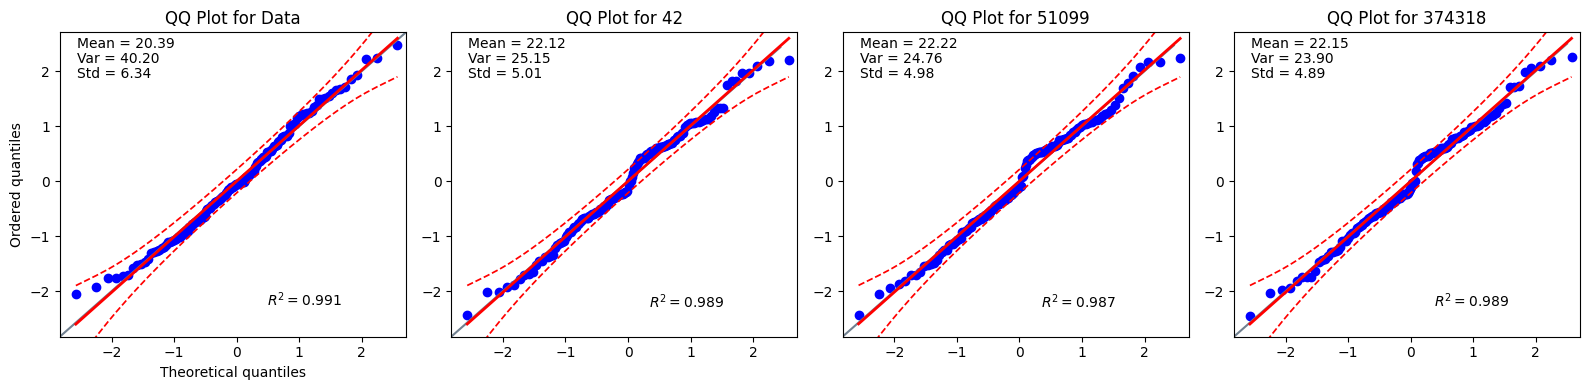

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

datasets = [df_overlaps["data"], df_overlaps["42"], df_overlaps["51099"], df_overlaps["374318"]]
titles = ["QQ Plot for Data", "QQ Plot for 42", "QQ Plot for 51099", "QQ Plot for 374318"]

for i, (data, title) in enumerate(zip(datasets, titles)):
    pg.qqplot(data, dist="norm", ax=axes[i], square=False)
    axes[i].set_title(title)
    mean_value = data.mean()
    var_value = data.var()
    std_value = data.std()
    axes[i].text(0.05, 0.95, f'Mean = {mean_value:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.05, 0.9, f'Var = {var_value:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.05, 0.85, f'Std = {std_value:.2f}', transform=axes[i].transAxes)

x_min, x_max = axes[0].get_xlim()
y_min, y_max = axes[0].get_ylim()

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

for i, ax in enumerate(axes):
    if i != 0:
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [29]:
for vocab, df, name in [(dict_data_vocab, df_data, "df_data"),
                        (dict_data_sample_vocab, df_data[df_data["dataset"].isin(dict_data_sample_vocab.keys())], "df_data_sample"),
                        (dict_42_vocab, df_42, "df_42"),
                        (dict_51099_vocab, df_51099, "df_51099"),
                        (dict_374318_vocab, df_374318, "df_374318")]:
    print(f"############## {name} ##############")
    print(f"### Total")
    overview_word_overlaps(vocab, "", "", exclude_diagonal=True)
    print(f"\n### Argument/Argument")
    overview_word_overlaps(vocab, "_argument", "_argument", exclude_diagonal=True)
    print(f"\n### No-Argument/No-Argument")
    overview_word_overlaps(vocab, "_no_argument", "_no_argument", exclude_diagonal=True)
    print(f"\n### Argument/No-Argument")
    overview_word_overlaps(vocab, "_argument", "_no_argument", exclude_diagonal=False)
    print()

############## df_data ##############
### Total
Overlaps (Vocabulary) min/max: (3.06, 36.05)
                         mean: 18.72
Overlaps (Stopwords) min/max: (66.67, 98.31)
                        mean: 86.35
Overlaps (Content) min/max: (2.73, 34.89)
                      mean: 17.59

### Argument/Argument
Overlaps (Vocabulary) min/max: (3.46, 35.19)
                         mean: 17.44
Overlaps (Stopwords) min/max: (44.79, 95.59)
                        mean: 76.51
Overlaps (Content) min/max: (2.75, 34.36)
                      mean: 15.43

### No-Argument/No-Argument
Overlaps (Vocabulary) min/max: (1.37, 34.31)
                         mean: 16.16
Overlaps (Stopwords) min/max: (48.03, 97.97)
                        mean: 80.04
Overlaps (Content) min/max: (1.14, 34.07)
                      mean: 14.76

### Argument/No-Argument
Overlaps (Vocabulary) min/max: (1.38, 49.14)
                         mean: 17.57
Overlaps (Stopwords) min/max: (52.19, 98.63)
                        mean: 

## Surface

In [30]:
df_data_correlation = get_correlation_matrix(df_data_statistics)
df_42_correlation = get_correlation_matrix(get_statistics(df_42.drop(columns=["split"])))
df_51099_correlation = get_correlation_matrix(get_statistics(df_51099.drop(columns=["split"])))
df_374318_correlation = get_correlation_matrix(get_statistics(df_374318.drop(columns=["split"])))
df_data_sample_correlation = df_data_correlation.loc[df_42_correlation.index, df_42_correlation.index]

In [31]:
df_correlations = pd.DataFrame(
    {
        "pair": melt_down_upper_triangle(df_data_sample_correlation)["pair"],
        "data": melt_down_upper_triangle(df_data_sample_correlation)["value"],
        "42": melt_down_upper_triangle(df_42_correlation)["value"],
        "51099": melt_down_upper_triangle(df_51099_correlation)["value"],
        "374318": melt_down_upper_triangle(df_374318_correlation)["value"]
    }
)

In [32]:
print(f"Test: Normality")
display(pg.normality(df_correlations.loc[:,"data":], alpha=0.01, method="normaltest").round(2))

Test: Normality


,W,pval,normal
data,29.28,0.0,False
42,17.06,0.0,False
51099,16.74,0.0,False
374318,15.77,0.0,False


In [33]:
print(f"\n>Test: Friedman")
df_correlations_long = df_correlations.melt(id_vars=["pair"], var_name="seed", value_name="correlation")
display(pg.friedman(data=df_correlations_long, dv="correlation", within="seed", subject="pair").round(2))


>Test: Friedman


,Source,W,ddof1,Q,p-unc
Friedman,seed,0.16,3,63.93,0.0


In [34]:
order_datasets = pd.read_csv("./datasets.csv")[["Dataset", "Definition"]]["Dataset"].tolist()
order_all = [ds for ds in order_datasets if ds in df_data_correlation.index]
order_sample = [ds for ds in order_datasets if ds in df_data_sample_correlation.index]

24 Surface-Features: Minimum ρ = 0.68


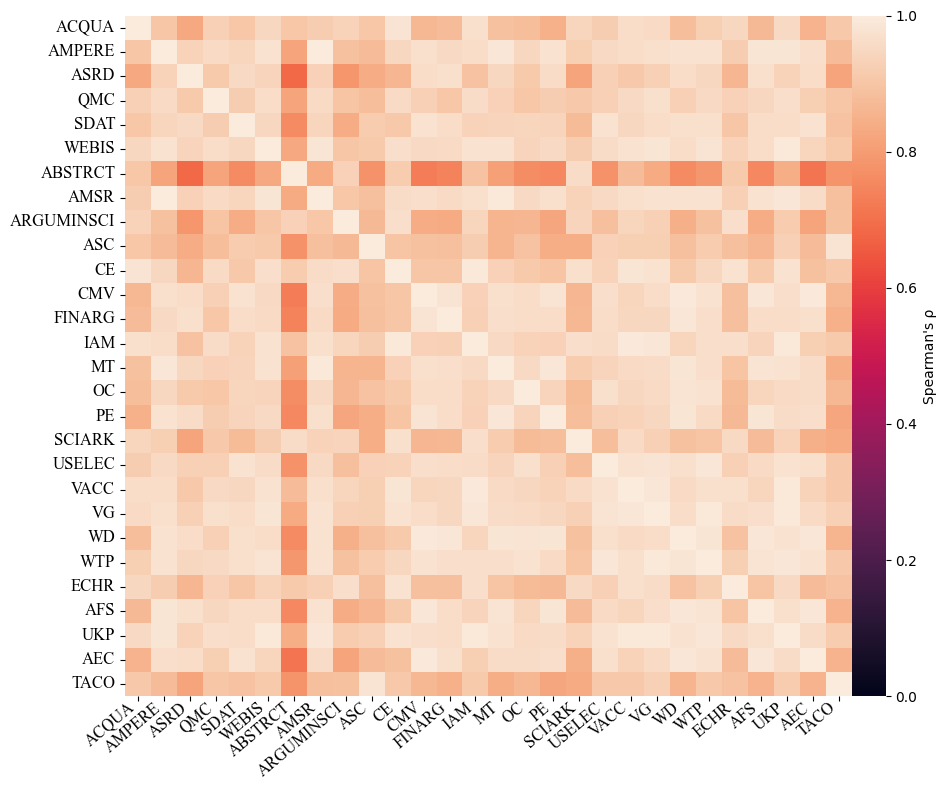

In [35]:
plot_correlation_heatmap(df_data_correlation.reindex(index=order_all, columns=order_all), "./output/images/all_sentences_spearman.pdf")

Minimum = 3.06
Maximum = 100.00


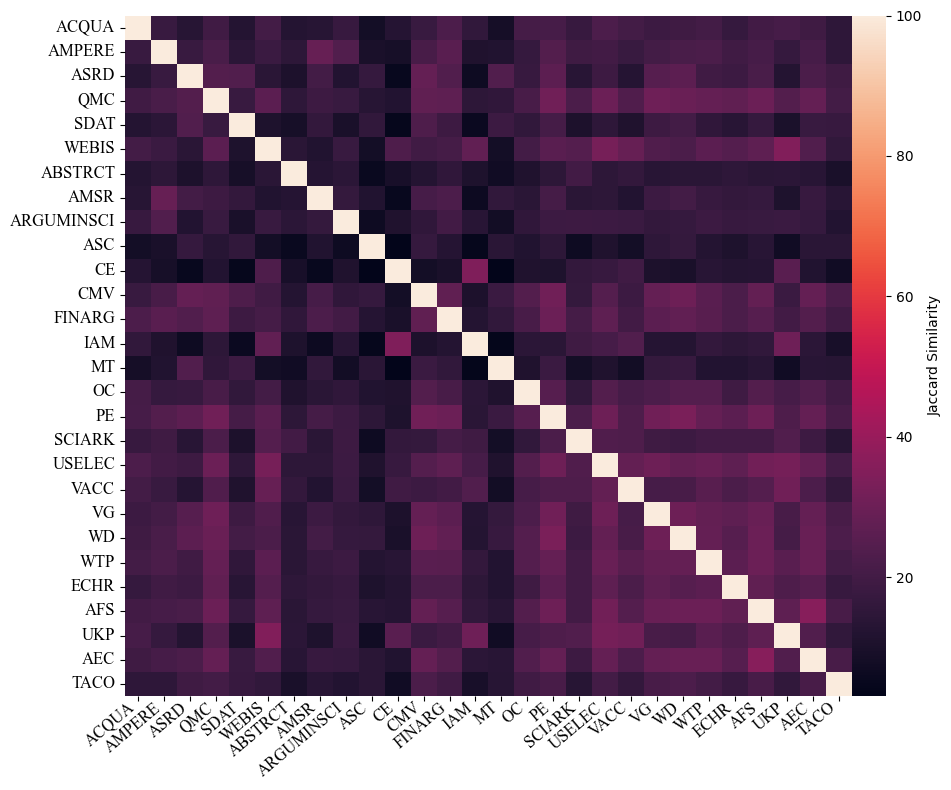

In [36]:
plot_overlaps_heatmap(word_overlaps_matrix(dict_data_vocab, "vocab", dict_data_vocab, "vocab").reindex(index=order_all, columns=order_all), "./output/images/all_words_jaccard.pdf")

# Transformer Token Distribution

In [37]:
def generate_token_distribution(df, model_name):
    # Initialize the tokenizer from the specified model
    tokenizer = AutoTokenizer.from_pretrained(model_name, verbose=False)
    token_counts = []
    # Tokenize each sentence in the dataframe and count the tokens
    for sentence in tqdm(df['sentence']):
        tokens = tokenizer.tokenize(sentence)
        token_counts.append(len(tokens))
    return token_counts

def calculate_max_sequence_ratio(integer_list, threshold=128):
    # Calculate the number of sequences below the threshold
    below_threshold = sum(1 for i in integer_list if i <= threshold)
    total_integers = len(integer_list)
    # Calculate the ratio of sequences below the threshold
    ratio_below_threshold = below_threshold / total_integers
    return round(100 * ratio_below_threshold, 2)

def plot_token_distribution(df):
    df_list = []
    # Generate token distributions
    all_tokens_wrapresentations = generate_token_distribution(df, "TomatenMarc/WRAPresentations")
    all_tokens_bert_base = generate_token_distribution(df, "bert-base-uncased")
    all_tokens_roberta_base = generate_token_distribution(df, "roberta-base")
    all_tokens_distilbert_base = generate_token_distribution(df, "distilbert-base-uncased")
    for all_tokens, model_name in [
        (all_tokens_wrapresentations, "WRAPresentations"),
        (all_tokens_bert_base, "BERT-base"),
        (all_tokens_roberta_base, "RoBERTa-base"),
        (all_tokens_distilbert_base, "DistilBERT-base")
    ]:
        # Calculate ratios
        ratio_all = calculate_max_sequence_ratio(all_tokens)
        # Prepare the data for seaborn
        tmp = pd.DataFrame({
            'Model': [model_name + f"\nTotal: {ratio_all}%"] * len(all_tokens),
            'Token Count': all_tokens
        })
        df_list.append(tmp)
    # Concatenate all DataFrames at once
    data = pd.concat(df_list)
    # Plotting the violin plot of token counts
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Token Count', y='Model', data=data, split=True, inner="quart", fill=True)
    plt.axvline(x=128, color='r', linestyle='--', linewidth=2)
    plt.title(f'Distribution of Token Counts with Instances below 128 Tokens')
    plt.xlim([0, 150])
    plt.grid(False)
    plt.show()

tokenizer_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

  0%|          | 0/373086 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/373086 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (759 > 512). Running this sequence through the model will result in indexing errors


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/373086 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/373086 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (759 > 512). Running this sequence through the model will result in indexing errors


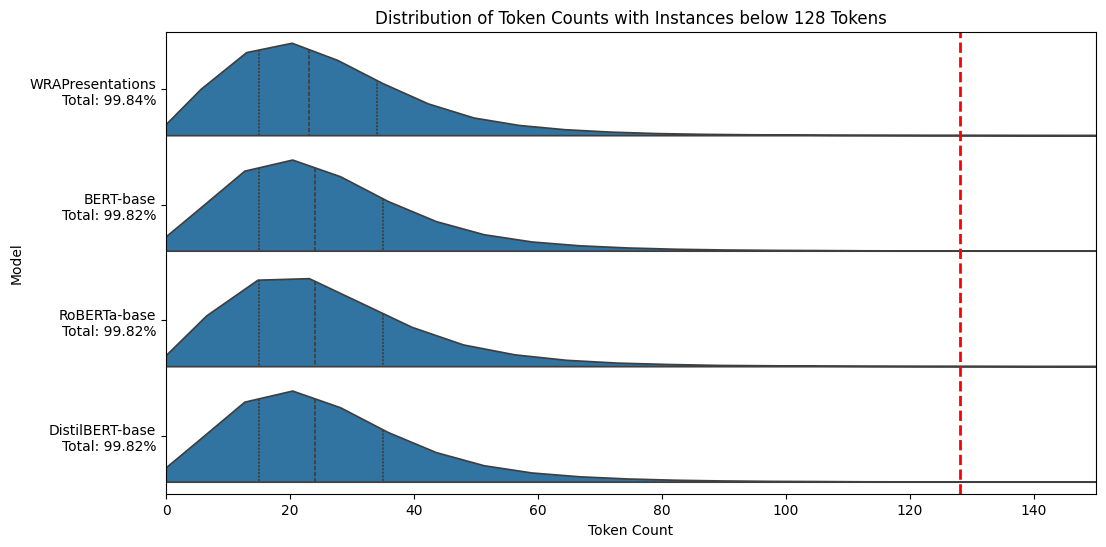

In [38]:
plot_token_distribution(df_data)

# Clean Up

In [ ]:
runtime.unassign()